# Delivered Late Random Forest GAT Hackathon LP Code

In [1]:
import numpy as np
import pandas as pd

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling  import SMOTE
from imblearn.pipeline import Pipeline as PipelineImb

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
from google.cloud.bigquery import Client

In [3]:
bigquery_client = Client(project='wf-gcp-us-ae-gat-rpt')

### Querying Data

In [4]:
sql = """
select a.*,OpcVol,OpcWeight,case when ship_to_first_movement_hour<=0 then 1
when ship_to_first_movement_hour<=4 and ship_to_first_movement_hour>0 then 2
else 3 end as quantile_ship_to_first_movement,
case when order_to_delivery_stated_day<3 then 1
when order_to_delivery_stated_day<5 and order_to_delivery_stated_day>=3 then 2
when order_to_delivery_stated_day<9 and order_to_delivery_stated_day>=5 then 3
when order_to_delivery_stated_day<13 and order_to_delivery_stated_day>=9 then 4
else 5 end as quantile_order_to_delivery_stated from `wf-gcp-us-ae-ops-prod.analyticstech_adhoc.tbl_summer_hackathon_delivery_late_lp` a
LEFT JOIN (select distinct opcopid,max(OpcHeight*OpcWidth*OpcDepth) as OpcVol,max(OpcWeight) as OpcWeight from `wf-gcp-us-ae-sql-data-prod.csn_order.tbl_order_product_carton` group by 1 order by 1) b on a.opid=b.opcopID
"""

In [5]:
df=bigquery_client.query(sql).to_dataframe()

In [6]:
df.head()

,ponum,opid,orderdate,orderdatetimestamp,SupplierId,Dom_Int,MkcID,mkcname,shipclass,shipdate,...,order_to_delivery_stated_day,hour_of_order_date,ship_ontime_cu,ship_ontime_su,deliveredlate,ServiceLevel,OpcVol,OpcWeight,quantile_ship_to_first_movement,quantile_order_to_delivery_stated
0,363291262,6057490501,2021-10-18,2021-10-18 11:04:20,29993,None,123,Plumbing - Vanities,2,2021-10-19 00:00:00,...,16.0,11,NaN,1,NaN,None,NaN,NaN,3,5
1,357554075,5989279065,2021-09-14,2021-09-14 09:21:27,42322,None,61,Furniture - Bedroom,3,2021-09-16 10:20:32,...,13.0,9,NaN,1,1.0,None,NaN,NaN,2,5
2,361794303,6039956949,2021-10-09,2021-10-09 21:05:37,42974,None,62,Furniture - Kitchen and Dining,2,2021-10-11 07:40:00,...,13.0,21,NaN,0,NaN,StANDard,NaN,NaN,2,5
3,361757040,6039608333,2021-10-09,2021-10-09 17:08:53,42904,None,61,Furniture - Bedroom,3,2021-10-11 07:40:00,...,13.0,17,NaN,0,NaN,Threshold,NaN,NaN,2,5
4,361420363,6036087731,2021-10-07,2021-10-07 16:16:09,42283,None,31,Upholstery - Core,2,2021-10-08 15:46:00,...,1.0,16,NaN,1,NaN,StANDard,NaN,NaN,2,1


### Looking at split between Delivered Late and not Late orders in database

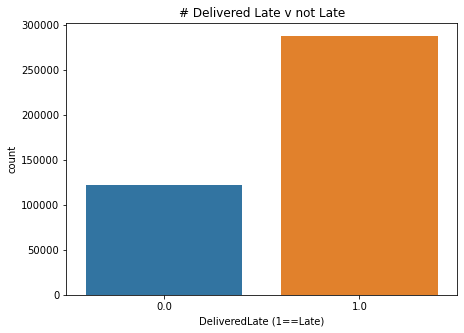

In [7]:
f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='deliveredlate', data=df)
_ = plt.title('# Delivered Late v not Late')
_ = plt.xlabel('DeliveredLate (1==Late)')

### Removing NA delivered late orders and using mean/mode to substitue NAs from the numerical/categorical features resepectively

In [8]:
df = df[df['deliveredlate'].notna()]

In [9]:
# Filling missing numerical values with mean
df['volume_last_48h'] = df['volume_last_48h'].fillna(df['volume_last_48h'].mean())

In [10]:
# Filling missing categorical values with mode
df['whname'] = df['whname'].fillna(df['whname'].mode()[0])
df['whname'] = df['whname'].apply(str)

df['mkcname'] = df['mkcname'].fillna(df['mkcname'].mode()[0])


df['quantile_ship_to_first_movement'] = df['quantile_ship_to_first_movement'].fillna(df['quantile_ship_to_first_movement'].mode()[0])

df['quantile_order_to_delivery_stated'] = df['quantile_order_to_delivery_stated'].fillna(df['quantile_order_to_delivery_stated'].mode()[0])
df['ServiceLevel'] = df['ServiceLevel'].fillna(df['ServiceLevel'].mode()[0])

### Looking at features to test how good they are at predicting Delivered Late individually and declaring categorical features as cat_fields

In [11]:
X=df[['quantile_ship_to_first_movement','quantile_order_to_delivery_stated','volume_last_48h','volume_last_24h','whname','mkcname','ServiceLevel']]
cat_fields = ['quantile_ship_to_first_movement','quantile_order_to_delivery_stated','whname', 'mkcname','ServiceLevel']

In [12]:
y = df['deliveredlate']

list_models = list()
for j, col in enumerate(X):
    _X = pd.DataFrame(df[col]).reset_index(drop=True)
    if col in cat_fields:
        enc = OneHotEncoder(categories="auto", handle_unknown="error", drop='first', sparse=False)
        _X_ohe = pd.DataFrame(enc.fit_transform(pd.DataFrame(_X)), columns=enc.get_feature_names_out()).reset_index(drop=True)
        _X = pd.concat([_X.drop(columns=col, axis=1), _X_ohe], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(_X, y, train_size=0.8, random_state=42)
    

    _model = PipelineImb([

             ('Imputer', SimpleImputer(missing_values=np.nan, strategy="median")), 
             ('Scaling', MinMaxScaler(clip=True)),
             ('RF', RandomForestClassifier(n_jobs=-1, oob_score = True, random_state=42))

                ])

    _model.fit(x_train, y_train)

    y_pred_proba = _model.predict_proba(x_test)[::,1]
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    print(f'col={col}, auc={auc}')
    
    list_models.append((col, auc))

df_list_models = pd.DataFrame(list_models, columns=['feature', 'AUC']).sort_values(by='AUC')

col=quantile_ship_to_first_movement, auc=0.5298133185802727
col=quantile_order_to_delivery_stated, auc=0.7660199586287534
col=volume_last_48h, auc=0.552211245090955
col=volume_last_24h, auc=0.5422321913749376
col=whname, auc=0.5505174754650778
col=mkcname, auc=0.5193230610574708
col=ServiceLevel, auc=0.558112216258156


### Check for Correlation between potential features to avoid highly correlated ones

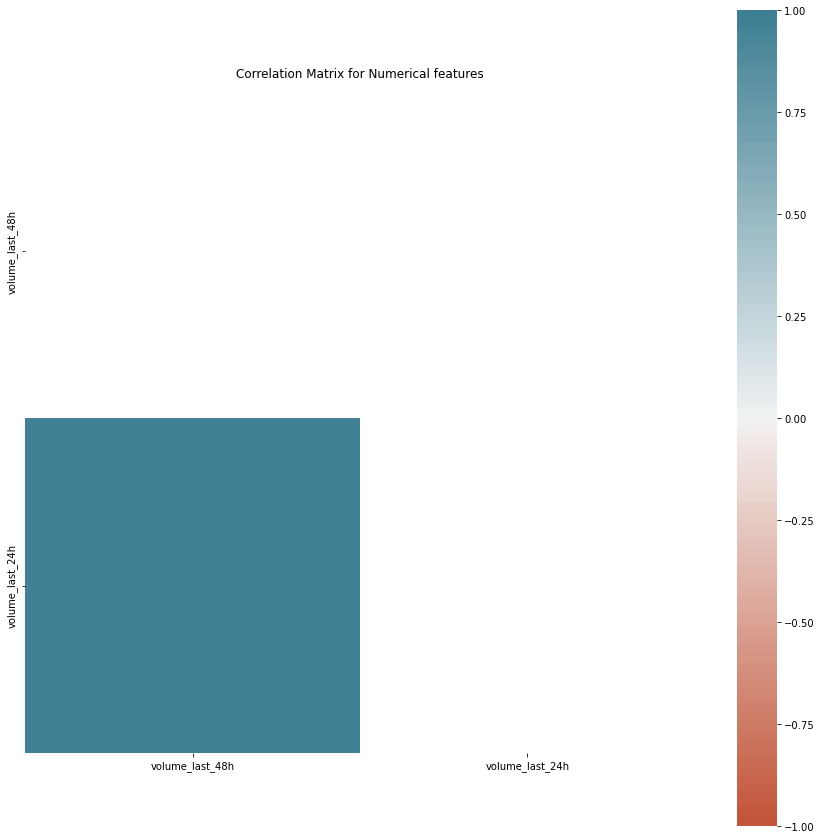

In [13]:
num_feat=X[['volume_last_48h','volume_last_24h']]
corr = num_feat.corr('pearson')
mask = np.triu(corr)
plt.figure(figsize=(15, 15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=100),
    square=True,
    mask=mask
)
plt.title('Correlation Matrix for Numerical features')
plt.show()

In [14]:
features=['quantile_order_to_delivery_stated','volume_last_48h','whname','ServiceLevel']

### Testing AUC Score of RF and LR models with different hyperparameters to identify best one

In [15]:
# Data
y = df['deliveredlate']
X = df[features].reset_index(drop=True)
cat_fields=['quantile_order_to_delivery_stated','whname', 'ServiceLevel']
#Encoder
enc = OneHotEncoder(categories="auto", handle_unknown="error", drop='first', sparse=False)
X_ohe = pd.DataFrame(enc.fit_transform(X[cat_fields]), columns=enc.get_feature_names_out()).reset_index(drop=True)
X = pd.concat([X.drop(columns=cat_fields, axis=1), X_ohe], axis=1)

# Defining the Pipeline for RF
model_rf = PipelineImb([
                     ('Imputer', SimpleImputer(missing_values=np.nan, strategy="median")), 
                     ('Scaling', MinMaxScaler(clip=True)),
                     ('RF', RandomForestClassifier(n_jobs=-1, oob_score = True, random_state=42))

                        ])

# Defining the grid
param_grid_rf ={

                     'RF__max_features': [10, 20, 'auto'],
                     'RF__min_samples_split': [5, 10],
                     'RF__max_depth': [20,30],
                     'RF__max_samples': [0.5, 0.8, None]

                }

# Searching best hyper-parametrization
CV_rf = GridSearchCV(model_rf, param_grid=param_grid_rf, cv=5, scoring='roc_auc', verbose=4)
res_rf = CV_rf.fit(X, y)


# --------------------------------------------------------------------------------------------------------------------------

# Defining the Pipeline for LgR
model_lgr = PipelineImb([

                     ('Imputer', SimpleImputer(missing_values=np.nan, strategy="median")), 
                     ('Scaling', MinMaxScaler(clip=True)),
                     ('LgR', LogisticRegression(n_jobs=-1, max_iter = 1000, random_state=42))

                    ])

# Defining the grid
param_grid_lgr = {

                    'LgR__solver': ['newton-cg', 'lbfgs']

                 }

# Searching best hyper-parametrization
CV_lgr = GridSearchCV(model_lgr, param_grid=param_grid_lgr, cv=5, scoring='roc_auc', verbose=4)
res_lgr = CV_lgr.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END RF__max_depth=20, RF__max_features=10, RF__max_samples=0.5, RF__min_samples_split=5;, score=0.800 total time=  16.4s
[CV 2/5] END RF__max_depth=20, RF__max_features=10, RF__max_samples=0.5, RF__min_samples_split=5;, score=0.798 total time=  14.9s
[CV 3/5] END RF__max_depth=20, RF__max_features=10, RF__max_samples=0.5, RF__min_samples_split=5;, score=0.798 total time=  14.8s
[CV 4/5] END RF__max_depth=20, RF__max_features=10, RF__max_samples=0.5, RF__min_samples_split=5;, score=0.800 total time=  14.9s
[CV 5/5] END RF__max_depth=20, RF__max_features=10, RF__max_samples=0.5, RF__min_samples_split=5;, score=0.799 total time=  15.0s
[CV 1/5] END RF__max_depth=20, RF__max_features=10, RF__max_samples=0.5, RF__min_samples_split=10;, score=0.801 total time=  14.7s
[CV 2/5] END RF__max_depth=20, RF__max_features=10, RF__max_samples=0.5, RF__min_samples_split=10;, score=0.799 total time=  14.9s
[CV 3/5] END RF__max_depth

### Finding best score and hyperparameters for both Random Forest and Logistic Regression

In [16]:
print(f'The best Score for Random Forest is: {res_rf.best_score_}')
print(f'The best Score for Logistic Regression is: {res_lgr.best_score_}')

The best Score for Random Forest is: 0.800457262502414
The best Score for Logistic Regression is: 0.7816290026775556


In [17]:
print(f'The best RF hyper-parametrization is: {res_rf.best_params_}')
print(f'The best LgR hyper-parametrization is: {res_lgr.best_params_}')

The best RF hyper-parametrization is: {'RF__max_depth': 20, 'RF__max_features': 'auto', 'RF__max_samples': 0.5, 'RF__min_samples_split': 10}
The best LgR hyper-parametrization is: {'LgR__solver': 'lbfgs'}


### Using best parameters for our model

In [18]:
# Data
y = df['deliveredlate']
X = df[features].reset_index(drop=True)
cat_fields=['quantile_order_to_delivery_stated','whname', 'ServiceLevel']

#Encoder
enc = OneHotEncoder(categories="auto", handle_unknown="error", drop='first', sparse=False)
X_ohe = pd.DataFrame(enc.fit_transform(X[cat_fields]), columns=enc.get_feature_names_out()).reset_index(drop=True)
X = pd.concat([X.drop(columns=cat_fields, axis=1), X_ohe], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None,max_depth=20, max_features='auto', max_samples=0.5, min_samples_split=10)
y_pred = rf.predict(x_test)


### Getting summary of model precision, recall and f1-score

In [19]:
from sklearn.metrics import classification_report
y_hat=rf.predict(x_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

         0.0       0.62      0.51      0.56     24485
         1.0       0.80      0.87      0.83     57503

    accuracy                           0.76     81988
   macro avg       0.71      0.69      0.70     81988
weighted avg       0.75      0.76      0.75     81988



### Finding true positive and false positive rate, ranking feature importance and plotting sample tree

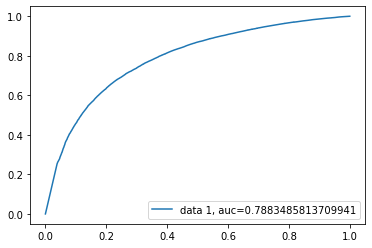

In [20]:
from sklearn.metrics import roc_curve, auc
test_results=[]
y_pred_proba = rf.predict_proba(x_test)[::,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_pred_proba)
roc_auc = auc(false_positive_rate, true_positive_rate)
test_results.append(roc_auc)
plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

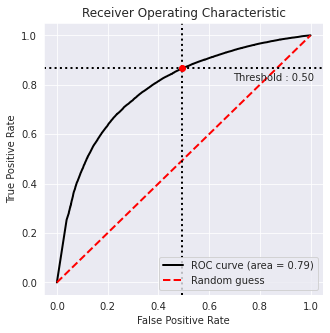

In [21]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred_proba, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

['volume_last_48h' 'quantile_order_to_delivery_stated_2'
 'quantile_order_to_delivery_stated_3'
 'quantile_order_to_delivery_stated_4'
 'quantile_order_to_delivery_stated_5' 'whname_Cranbury'
 'whname_Cranbury2' 'whname_CranburyLargeParcel' 'whname_Erlanger'
 'whname_Florence' 'whname_Hebron' 'whname_Jacksonville'
 'whname_Lancaster' 'whname_Lathrop' 'whname_McDonough'
 'whname_Mississauga' 'whname_PerrisCA' 'whname_PerrisSmallParcel'
 'whname_PortWentworth' 'ServiceLevel_Backyard' 'ServiceLevel_Pick Up'
 'ServiceLevel_Room of Choice' 'ServiceLevel_StANDard'
 'ServiceLevel_Threshold' 'ServiceLevel_other']


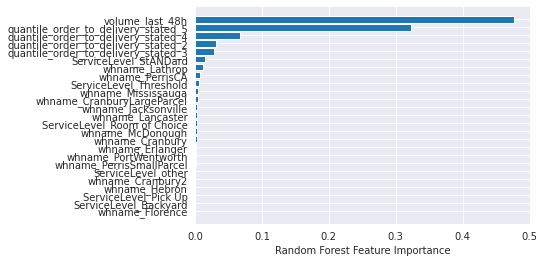

In [22]:
importance=rf.feature_importances_
sorted_idx = rf.feature_importances_.argsort()
plt.barh(rf.feature_names_in_[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
print(rf.feature_names_in_)

In [23]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, x_test, y_test)

<bound method Artist.get_in_layout of <Figure size 432x288 with 1 Axes>>

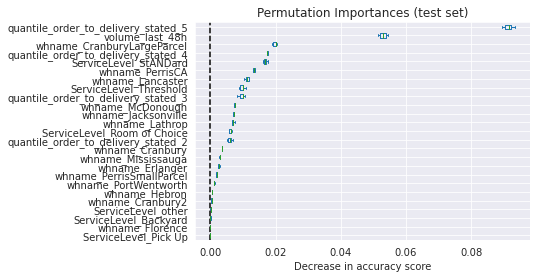

In [24]:
sorted_importances_idx = perm_importance.importances_mean.argsort()
importances = pd.DataFrame(
    perm_importance.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.get_in_layout

In [25]:
print(f"RF train accuracy: {rf.score(x_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(x_test, y_test):.3f}")

RF train accuracy: 0.802
RF test accuracy: 0.759


In [26]:
y_pred=pd.DataFrame(y_pred)

In [27]:
y_testv2=pd.DataFrame(y_test.index)

In [28]:
y_predv2=pd.concat([y_pred,y_testv2],axis=1)

In [29]:
y_predv2.columns=['preds','pred_index']

In [30]:
y_predv2

,preds,pred_index
0,0.0,397541
1,1.0,152306
2,0.0,132635
3,0.0,256853
4,0.0,398917
...,...,...
81983,1.0,287686
81984,1.0,75841
81985,1.0,102085
81986,1.0,89015


In [31]:
df['pred_index']=df.index

In [32]:
output=pd.merge(df,y_predv2,on='pred_index',how='left',indicator=True)

In [33]:
output['_merge'].value_counts()

left_only     327949
both           81988
right_only         0
Name: _merge, dtype: int64

In [34]:
output

,ponum,opid,orderdate,orderdatetimestamp,SupplierId,Dom_Int,MkcID,mkcname,shipclass,shipdate,...,ship_ontime_su,deliveredlate,ServiceLevel,OpcVol,OpcWeight,quantile_ship_to_first_movement,quantile_order_to_delivery_stated,pred_index,preds,_merge
0,357554075,5989279065,2021-09-14,2021-09-14 09:21:27,42322,None,61,Furniture - Bedroom,3,2021-09-16 10:20:32,...,1,1.0,StANDard,NaN,NaN,2,5,1,NaN,left_only
1,357493345,5988565812,2021-09-13,2021-09-13 20:25:36,33529,None,61,Furniture - Bedroom,2,2021-09-15 18:06:03,...,1,1.0,StANDard,NaN,NaN,3,2,11,NaN,left_only
2,355333805,5965426421,2021-09-03,2021-09-03 07:25:51,27975,None,28,Rugs,2,2021-09-05 08:20:51,...,1,1.0,StANDard,NaN,NaN,3,5,12,0.0,both
3,357850108,5992185769,2021-09-15,2021-09-15 22:19:03,27743,None,62,Furniture - Kitchen and Dining,3,2021-09-16 03:26:20,...,0,1.0,StANDard,NaN,NaN,2,5,17,NaN,left_only
4,356533817,5977075156,2021-09-08,2021-09-08 01:47:52,27754,Domestic,22,Outdoor,2,2021-09-08 15:49:32,...,1,1.0,StANDard,NaN,NaN,3,1,56,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409932,395008920,6410137892,2022-03-30,2022-03-30 18:07:03,62666,Domestic,31,Upholstery - Core,3,2022-03-31 13:19:22,...,1,1.0,StANDard,NaN,NaN,1,1,415074,1.0,both
409933,395119404,6367721969,2022-03-31,2022-03-31 13:03:34,33633,Domestic,31,Upholstery - Core,2,2022-04-02 07:37:23,...,1,1.0,StANDard,NaN,NaN,3,1,415075,NaN,left_only
409934,394842360,6405996859,2022-03-29,2022-03-29 18:08:54,52274,Domestic,43,Mattresses,3,2022-03-30 07:49:08,...,0,1.0,StANDard,NaN,NaN,1,2,415076,1.0,both
409935,394967538,6405915693,2022-03-30,2022-03-30 14:08:50,29492,Domestic,123,Plumbing - Vanities,3,2022-03-31 13:02:28,...,1,1.0,StANDard,NaN,NaN,1,1,415077,NaN,left_only


In [35]:
output.to_csv(r'delivered_late_prediction.csv')